In [1]:
import pm4py
pm4py.__version__

'1.2.13'

# Decision Points

> Investigate how patients are referred for further treatment by means of a decision tree. Describe the factors that you observe.

## Data loading

Import the original log and modify column names and datatypes for the following analysis.

In [2]:
import os
import pandas as pd
import numpy as np
from pm4py.objects.log.importer.xes import factory as xes_import_factory
from pm4py.objects.petri.importer import factory as pnml_importer
from pm4py.objects.conversion.log import factory as log_converter
from pm4py.util import constants

PROJ_ROOT = os.path.abspath(os.path.pardir)

# load csv from disk
df_log_Q4 = pd.read_csv(PROJ_ROOT+"/data/log.csv")

# convert timestamp columns to datetime friendly format
df_log_Q4['Timestamp'] = pd.to_datetime(df_log_Q4['Timestamp'])
df_log_Q4['start_timestamp'] = pd.to_datetime(df_log_Q4['start_timestamp'])

#rename some column for better algorithm compatibillity
df_log_Q4 = df_log_Q4.rename(columns={"Age": "case:Age", "Insurance": "case:Insurance", "PatientName": "case:PatientName", "Timestamp": "time:timestamp"})


---

# a)
> Create a decision tree of reasonable complexity using the available attributes in the log. 

In this section we are interested in the kind of treatment that a patient will undergo based on certain properties.  For this we want to create decision trees based on case attributes that can give us deeper insights into which patients recieve which treatment.

To do so we are interested in which cases contain certain treatment related events. PM4Py offers a decision tree module, that creates a decision tree predicting the end event of a case from the case properties. Since we know that eventually all patients will be discharged from our previous analysis, most of the cases will have a discharge end event. From this we cannot infer which treatment was performed before the discharge. Because of this, before creating the decision tree, we will cut off all traces when a certain event occurs. This event is one of a set of events that describe the treatment of the patient. The events included in this set can be seen below. They are either related to a certain kind of treatment, or a discharge. The discharge events are included for cases that do not recieve any treatment.

In [3]:
NEW_END_ACTIVITIES = ["Treatment A1", "Treatment A2", "Treatment B", "Discharge", "Discharge Test", "Discharge Init Exam"]

In the following step the original event log is filtered in such a way, that all events that occurred after one of the above events in a case will be discarded.

In [4]:
#remove all events after a final decision was made (slow)
treatment_df = pd.DataFrame(index=np.arange(0, len(df_log_Q4)), columns=["case:concept:name", "concept:name", "org:resource", "case:PatientName", "case:Age", "case:Insurance", "start_timestamp", "Timestamp", "@@duration"])

current_id = -1
keep = True
count = 0

# go through the sorted events on a case basis
# if an event from the new end activities is found, discard all further events from that case
for row in df_log_Q4.itertuples():
    if current_id != row[1]:
        current_id = row[1]
        keep = True

    if keep:
        if row[2] in NEW_END_ACTIVITIES:
            keep = False
            
        treatment_df.loc[count] = row[1:]
        count += 1         

# drop nil rows that will occur because after filtering there are fewer events
treatment_df = treatment_df.dropna()


In [5]:
treatment_df.head(13)

,case:concept:name,concept:name,org:resource,case:PatientName,case:Age,case:Insurance,start_timestamp,Timestamp,@@duration
0,1,Register,Alexander,Hermann the 1.,51,STAT,2020-06-01 06:00:00,2020-06-01 06:08:53,533
1,1,Initial Exam,Anna,Hermann the 1.,51,STAT,2020-06-01 06:10:48,2020-06-01 06:25:43,895
2,1,Initial Exam Decision,"Amelie,Anna",Hermann the 1.,51,STAT,2020-06-01 06:26:43,2020-06-01 06:31:52,309
3,1,Inform about Isolation,Alexander,Hermann the 1.,51,STAT,2020-06-01 06:33:45,2020-06-01 06:33:45,0
4,1,Test III,Anna,Hermann the 1.,51,STAT,2020-06-01 06:35:35,2020-06-01 07:03:47,1692
5,1,Test III Decision,"Adrian,Anna",Hermann the 1.,51,STAT,2020-06-01 07:03:47,2020-06-01 07:08:06,259
6,1,Inform Authority Fill Form,Alina,Hermann the 1.,51,STAT,2020-06-01 07:09:57,2020-06-01 07:17:47,470
7,1,Referral,Adrian,Hermann the 1.,51,STAT,2020-06-01 07:09:57,2020-06-01 07:18:48,531
8,1,Inform Authority Send Form,Alina,Hermann the 1.,51,STAT,2020-06-01 07:17:57,2020-06-01 07:20:07,130
9,1,Register Facility,Bernhard,Hermann the 1.,51,STAT,2020-06-01 08:21:45,2020-06-01 08:31:18,573


We can see that case 1 now ends with Treatment B instead of an discharge event. In the next step we will convert the log into an PM4Py event log as seen before.

In [6]:
#convert to event log
# map dataset columns to PM4Py keys
param_keys_Q4 = {constants.PARAMETER_CONSTANT_CASEID_KEY: 'case:concept:name',
            constants.PARAMETER_CONSTANT_RESOURCE_KEY: 'org:resource', 
            constants.PARAMETER_CONSTANT_ACTIVITY_KEY: 'concept:name',
            constants.PARAMETER_CONSTANT_TIMESTAMP_KEY: 'time:timestamp',
            constants.PARAMETER_CONSTANT_START_TIMESTAMP_KEY: 'start_timestamp'}

treatment_log = log_converter.apply(treatment_df, parameters=param_keys_Q4)

Since not all cases contain one of the new end activities, there are still traces in the event log that do not end with one of the specified activities. In order to keep just the cases that end on one of the specified events we use the end activitiy filter provided by PM4Py.

In [7]:
from pm4py.algo.filtering.log.end_activities import end_activities_filter

treatment_log = end_activities_filter.apply(treatment_log, NEW_END_ACTIVITIES)

After preprocessing the log we can now create a decision tree from it. In the first step of this, we use PM4Py to create the data, targets and classes that will be passed to the sklearn decision tree algorithm. In this step we need to specify which properties of the event log should be used for the decision tree creation. We can speecifiy trace based and event based attributes.

For our first iteration we included all of the sensible log attributes (for example patient name was removed as it provides no information).

In [8]:
from pm4py.objects.log.util import get_log_representation
from pm4py.objects.log.util import get_class_representation

# preprocess the log for decision tree mining
str_trace_attributes = ["Insurance"]
str_event_attributes = ["org:resource", "concept:name"]
num_trace_attributes = ["Age"]
num_event_attributes = ["@@duration"]

data, feature_names = get_log_representation.get_representation(treatment_log, str_trace_attributes, str_event_attributes,
                                                              num_trace_attributes, num_event_attributes)

target, classes = get_class_representation.get_class_representation_by_str_ev_attr_value_value(treatment_log, "concept:name")

In [9]:
from sklearn import tree

#calculate the decision tree

# 0 treatmentB, 1 treatment A1, 2 discharge test, 3 discharge init, 4 treatment a2
classifier = tree.DecisionTreeClassifier()
classifier.fit(data, target)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [10]:
from pm4py.visualization.decisiontree import factory as dt_vis_factory
#visualize the obtained decision tree

decision_tree_vis = dt_vis_factory.apply(classifier, feature_names, classes)

figures_dir = os.path.join(PROJ_ROOT, 'report', 'figures')
decision_tree_vis.render(os.path.join(figures_dir, 'q4_tree_all'),
                 format='pdf',
                 view=True)

'/Users/Tom/Documents/Uni/4. Semester M/Advanced Process Mining/Assignments/Assignment 1/APM-A1/report/figures/q4_tree_all.pdf'

The obtained tree is able to perfectly classify all cases, which is unexpected. A closer investigation shows that the tree simply uses the target events themselves to classify the cases, which of course is not wanted. As some events are always performed by the same resources, the same holds for the resource attribute. The two attributes are therefore not suited to be included in a sensible decision tree for this taks.

Furthermore we see that the tree once splits using the duration of an event. Since the tree holds no information about which event is related to this duration, we cannot derive meaningful results from this split. The attribute is therefore removed as well. With the remaining age and insurance attributes, we create a new decision tree in the following.

In [11]:
# preprocess the log for decision tree mining
str_trace_attributes = ["Insurance"]
str_event_attributes = []
num_trace_attributes = ["Age"]
num_event_attributes = []

data, feature_names = get_log_representation.get_representation(treatment_log, str_trace_attributes, str_event_attributes,
                                                              num_trace_attributes, num_event_attributes)

target, classes = get_class_representation.get_class_representation_by_str_ev_attr_value_value(treatment_log, "concept:name")


Since the _Discharge Init Exam_ event is disproportionally more frequent than all other classes, we need to introduce some normalization in order to obtain a sensible tree. (Else all nodes would have the same label for a small tree) Additionally, since the tree is not able to perfectly classify all cases anymore, we have to limit the depth and maximum number of child nodes in order to obtain readable results.

In [12]:
#calculate the decision tree

# 0 treatmentB, 1 treatment A1, 2 discharge test, 3 discharge init, 4 treatment a2
classifier = tree.DecisionTreeClassifier(max_depth=7,max_leaf_nodes=8,class_weight={0: 0.6, 1: 1, 2: 1, 3: 0.5, 4: 2})
classifier.fit(data, target)

DecisionTreeClassifier(class_weight={0: 0.6, 1: 1, 2: 1, 3: 0.5, 4: 2},
                       criterion='gini', max_depth=7, max_features=None,
                       max_leaf_nodes=8, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort=False, random_state=None, splitter='best')

In [13]:
#visualize the obtained decision tree

decision_tree_vis = dt_vis_factory.apply(classifier, feature_names, classes)

figures_dir = os.path.join(PROJ_ROOT, 'report', 'figures')
decision_tree_vis.render(os.path.join(figures_dir, 'q4_tree_min'),
                 format='pdf',
                 view=True)

'/Users/Tom/Documents/Uni/4. Semester M/Advanced Process Mining/Assignments/Assignment 1/APM-A1/report/figures/q4_tree_min.pdf'

The new decision tree with an reduced attribute set is much more interpretable. For example we see that patients older than 63.5 years that have a state insurance are more often discharged after the initial exam than ones with a private insurance. This group recieves treatment B more frequently.

Furthermore we can observe, that really young patients (<=15.5) are more often discharged after having been tested, while older patients between 15.5 and 39.5 years are more often directly discharged after thee initial exam.

In general we can observe that privately insured patients recieve any kind of treatment more frequently and are less often discharged without treatment.


---

# b)
> Since it is likely that the resources at the treatment facilities are limited, implement a function that assigns a(n) (estimate) of the number of patients at each facility to each event. To this end, you have to decide which event occurs at which facility based on your analysis in question 2. Create a decision tree of reasonable complexity using this derived attribute.

Based on our analysis in Q2, we know that the respurces are heavily related to the facilities. More concrete the first letter of the name of the resource corresponds to the facility of the resource. We will therefore use this property for the distinction between the different facilities.

For this we first create a new property called facillity that is derived from the first letter of the resource of the event. Based on this we add a new column that documents the move of a patient between two facilities.

In [14]:
def create_fac(row):
    return row["org:resource"][0]

def create_fac_move(row):
    patient = row["case:concept:name"]
    last_patient = row["last_patient"]
    next_patient = row["next_patient"]
    
    facility = row["facility"]
    last_facility = row["last_facility"]
    
    if patient == last_patient:
        if next_patient == patient:
            if last_facility is not None:
                return str(last_facility)+"->"+str(facility)
            else:
                return "start->"+str(facility)
        else:
            return str(facility)+"->end"
    else:
        return "start->"+str(facility)
    

df_fac = treatment_df.copy()

#obtain the facility from the resource name for all events
df_fac["facility"] = df_fac.apply(lambda row: create_fac(row), axis=1)

#Find out which facilities exist
pd.unique(df_fac["facility"])

array(['A', 'B', 'D', 'I', 'C', 'H'], dtype=object)

In [15]:
#shift the facility and patient column down, so each row knows what the last facility and patient was
df_fac["last_facility"] = df_fac["facility"].shift(1)
df_fac["last_patient"] = df_fac["case:concept:name"].shift(1)

#shift the patient row up so we know what the next patient is (important for last event)
df_fac["next_patient"] = df_fac["case:concept:name"].shift(-1)

#create a move in the form last_facility->current_facility for each event
df_fac["fac_move"] = df_fac.apply (lambda row: create_fac_move(row), axis=1)

df_fac = df_fac.drop(["facility", "last_facility", "last_patient", "next_patient"], 1)
df_fac.head(24)

,case:concept:name,concept:name,org:resource,case:PatientName,case:Age,case:Insurance,start_timestamp,Timestamp,@@duration,fac_move
0,1,Register,Alexander,Hermann the 1.,51,STAT,2020-06-01 06:00:00,2020-06-01 06:08:53,533,start->A
1,1,Initial Exam,Anna,Hermann the 1.,51,STAT,2020-06-01 06:10:48,2020-06-01 06:25:43,895,A->A
2,1,Initial Exam Decision,"Amelie,Anna",Hermann the 1.,51,STAT,2020-06-01 06:26:43,2020-06-01 06:31:52,309,A->A
3,1,Inform about Isolation,Alexander,Hermann the 1.,51,STAT,2020-06-01 06:33:45,2020-06-01 06:33:45,0,A->A
4,1,Test III,Anna,Hermann the 1.,51,STAT,2020-06-01 06:35:35,2020-06-01 07:03:47,1692,A->A
5,1,Test III Decision,"Adrian,Anna",Hermann the 1.,51,STAT,2020-06-01 07:03:47,2020-06-01 07:08:06,259,A->A
6,1,Inform Authority Fill Form,Alina,Hermann the 1.,51,STAT,2020-06-01 07:09:57,2020-06-01 07:17:47,470,A->A
7,1,Referral,Adrian,Hermann the 1.,51,STAT,2020-06-01 07:09:57,2020-06-01 07:18:48,531,A->A
8,1,Inform Authority Send Form,Alina,Hermann the 1.,51,STAT,2020-06-01 07:17:57,2020-06-01 07:20:07,130,A->A
9,1,Register Facility,Bernhard,Hermann the 1.,51,STAT,2020-06-01 08:21:45,2020-06-01 08:31:18,573,A->B


As can be seen above, each event now contains the information about the facility move that has happened. We assume that the move between facilities happens at the start time of the current event. We can now use this move record to calculate for each event, how many patients currently are assigned to a certain facility.


In [16]:
FACILITIES = ["A", "B", "C", "D", "I", "H"]
results = np.zeros(len(df_fac))

def get_fac_count(facility_index, row, index):
    facility = FACILITIES[facility_index]
    facs = row[1].split("->")

    old_fac = facs[0]
    current_fac = facs[1]

    old_count = 0
    if index > 0:
        old_count = results[index-1]
    else:
        #set fitting initial values, obtained from a prior run of the algorithm
        if facility == "A":
            old_count = 10
        elif facility == "I":
            old_count = 20
        elif facility in ["A", "B", "C", "D"]:
            old_count = 1
        
    new_count = old_count

    #increase / decrease count based on facility move
    if old_fac != current_fac:
        if current_fac == facility:
            new_count = old_count + 1
        elif old_fac == facility:
            if old_count > 0:
                new_count = old_count - 1
            
    return new_count

#sort the dataframe by start timestamp
df_fac = df_fac.sort_values("start_timestamp").reset_index(drop=True)

df_count = df_fac[["fac_move"]].copy()

# assign patient counts to all events for all facilities
for facility_index in range(0, len(FACILITIES)):
    facility = FACILITIES[facility_index]
    results = np.zeros(len(df_fac))
    index = 0
    
    for row in df_count.itertuples():
        results[index] = get_fac_count(facility_index, row, index)
        index = index + 1

    df_count[facility] = results
    
# join with the original dataframe to keep all value columns  
df_fac_count = df_fac.join(df_count[FACILITIES])


Below we can see the resulting dataframe with the values for the facilities.

In [17]:
df_fac_count.head(15)

,case:concept:name,concept:name,org:resource,case:PatientName,case:Age,case:Insurance,start_timestamp,Timestamp,@@duration,fac_move,A,B,C,D,I,H
0,1,Register,Alexander,Hermann the 1.,51,STAT,2020-06-01 06:00:00,2020-06-01 06:08:53,533,start->A,11.0,1.0,1.0,1.0,20.0,0.0
1,1,Initial Exam,Anna,Hermann the 1.,51,STAT,2020-06-01 06:10:48,2020-06-01 06:25:43,895,A->A,11.0,1.0,1.0,1.0,20.0,0.0
2,1,Initial Exam Decision,"Amelie,Anna",Hermann the 1.,51,STAT,2020-06-01 06:26:43,2020-06-01 06:31:52,309,A->A,11.0,1.0,1.0,1.0,20.0,0.0
3,1,Inform about Isolation,Alexander,Hermann the 1.,51,STAT,2020-06-01 06:33:45,2020-06-01 06:33:45,0,A->A,11.0,1.0,1.0,1.0,20.0,0.0
4,1,Test III,Anna,Hermann the 1.,51,STAT,2020-06-01 06:35:35,2020-06-01 07:03:47,1692,A->A,11.0,1.0,1.0,1.0,20.0,0.0
5,1,Test III Decision,"Adrian,Anna",Hermann the 1.,51,STAT,2020-06-01 07:03:47,2020-06-01 07:08:06,259,A->A,11.0,1.0,1.0,1.0,20.0,0.0
6,1,Inform Authority Fill Form,Alina,Hermann the 1.,51,STAT,2020-06-01 07:09:57,2020-06-01 07:17:47,470,A->A,11.0,1.0,1.0,1.0,20.0,0.0
7,1,Referral,Adrian,Hermann the 1.,51,STAT,2020-06-01 07:09:57,2020-06-01 07:18:48,531,A->A,11.0,1.0,1.0,1.0,20.0,0.0
8,1,Inform Authority Send Form,Alina,Hermann the 1.,51,STAT,2020-06-01 07:17:57,2020-06-01 07:20:07,130,A->A,11.0,1.0,1.0,1.0,20.0,0.0
9,1,Register Facility,Bernhard,Hermann the 1.,51,STAT,2020-06-01 08:21:45,2020-06-01 08:31:18,573,A->B,10.0,2.0,1.0,1.0,20.0,0.0


As can be seen in the dataframe above, we have assigned an initial patient count to all of the facilities. This was done because the given dataset is presumably not complete and the facilities have also operated in the time that is not captured by the dataset. The initial values were chosen on the metrics that can be seen below. A fitting initial value for the facilities was chosen based on the mean value of patients from a previous run of the algorithm and a visual interpretation of the patient counts.

Below, the patient counts of two of the facilities are plotted (A blue, I orange). We can see that there is some kind of weekly pattern and that the patient count in facility A steadily rises up until the end.

In [19]:
from matplotlib import pyplot as plt
pd.plotting.register_matplotlib_converters()

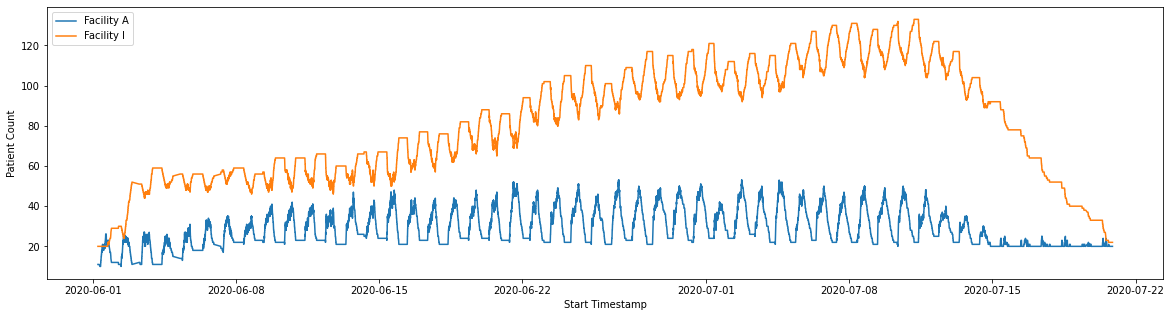

In [20]:
plt.figure(figsize=(20,5))
plt.plot(df_fac_count["start_timestamp"], df_fac_count["A"], label="Facility A")
plt.plot(df_fac_count["start_timestamp"], df_fac_count["I"], label="Facility I")
plt.xlabel("Start Timestamp")
plt.ylabel("Patient Count")
plt.legend(loc="upper left")

plt.show()


In [21]:
# check what initial value to assing to the patient counts
df_fac_count.mean()

case:concept:name    802.000338
case:Age              46.507080
@@duration           469.482675
A                     33.189436
B                      0.366549
C                      0.379549
D                      0.555260
I                     82.229885
H                      0.000000
dtype: float64

In the next steps, the obtained dataframe with the counts is transformed into an event log again. As parameters for the decision tree we only choose the patient count of the facilities. Again we want to predict the kind of treatment a patient recieves.

In [ ]:
fac_count_log = log_converter.apply(df_fac_count, parameters=param_keys_Q4)

In [ ]:
# preprocess the log for decision tree mining
str_trace_attributes = []
str_event_attributes = []
num_trace_attributes = []
num_event_attributes = FACILITIES

data, feature_names = get_log_representation.get_representation(fac_count_log, str_trace_attributes, str_event_attributes,
                                                              num_trace_attributes, num_event_attributes)

target, classes = get_class_representation.get_class_representation_by_str_ev_attr_value_value(fac_count_log, "concept:name")


In [ ]:
#calculate the decision tree

# 0 treatmentB, 1 treatment A1, 2 discharge test, 3 discharge init, 4 treatment a2
classifier = tree.DecisionTreeClassifier(max_depth=8,max_leaf_nodes=8,class_weight={0: 0.6, 1: 1, 2: 1, 3: 0.5, 4: 2})
classifier.fit(data, target)

In [ ]:
#visualize the obtained decision tree

decision_tree_vis = dt_vis_factory.apply(classifier, feature_names, classes)

figures_dir = os.path.join(PROJ_ROOT, 'report', 'figures')
decision_tree_vis.render(os.path.join(figures_dir, 'q4_facility_tree'),
                 format='pdf',
                 view=True)

We obtain a decision tree that is splitting the cases based on the number of patients in each of the facilities. 

The first split is done on the A facility. We observe that when there are fewer (less than 21) patients in facility A, more treatments are prescribed and less patients are discharged at the initial exam. This could mean that the facility is somehow overloaded when there are many patients, which influences the decision making. 

On the second level we can also observe that there are more initial discharges if there are not many patients in facility C. As discovered in Q2, facility C is mainly concerned with checking treatments, so the reason here might be that when there are more people discharged, there is less need for treatment checks. On the other hand this may also indicate a potential bottleneck in C: There are not enough resources to perform checks, so patients are more frequently discharged.

We also see that the facilities B and D were never used as a splitting criterion, which might indicate that the number of patients in these facilities has no big influence on the treatment and therefore there are enough resources in these facilities.

Facility I is a good indicator for the overall number of _active_ patients that are currently in the process, as patients stay in that facility for a longer time (for the control calls). The I facality patient count is therefore also used as a splitting criterion for some nodes. We again observe that treatments are less frequent for higher patient numbers.

In a last step we calculated the number of resources in each facility to compare those numbers with the obtained patient numbers. The results can be seen below.


In [ ]:
from collections import Counter

# find out how many resources there are in every facility
resources = list(df_log_Q4["Resource"])
resources = [r for rs in (resource.split(",") for resource in resources) for r in rs]
resources = list(set(resources))
resources = [r[0] for r in resources]
Counter(resources)

We see that, altough facility A has the highest patient load, it has the lowest number of resources compared to the other "normal" facilities B, C and D. This is a further indicator that facility A might be understaffed.

We also see that there is only one resource in facility I, we have already observed this fact in Q2. This is probably the case as the control calls are somehow automated and performed by a single system, so there can be no resource bottlenecks here.